In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import pudl
import sqlalchemy as sa
import sys
import os
import matplotlib.pyplot as plt
import logging
import requests
import pandas as pd

In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]
pd.options.display.max_columns = None

In [4]:
def plot_filled_rolled_plant(frc_rf, frc_og):
    plant_id =frc_rf[frc_rf.fuel_cost_from_eiaapi].plant_id_eia.sample().values[0]
    while len(frc_og[(frc_og.plant_id_eia == plant_id)
               & (frc_og.fuel_cost_per_mmbtu.notnull())]) == 0:
        plant_id =frc_rf[frc_rf.fuel_cost_from_eiaapi].plant_id_eia.sample().values[0]
    for df,frc_type in zip([frc_rf,frc_og,], ['Fill&Roll','Og']):
        plant = df[df.plant_id_eia == plant_id]
        for fuel in plant.fuel_type_code_pudl.unique():
            plant_fuel = plant[plant.fuel_type_code_pudl == fuel]
            plt.plot(plant_fuel.report_date, plant_fuel.fuel_cost_per_mmbtu, label=f"{frc_type} {fuel}")
    plt.ylabel("Fuel cost $/mmBTU")
    plt.xlabel("Report Date")
    plt.title(f"Results of FRC Table for {plant_fuel.plant_name_eia.unique()}")
    plt.legend()
    plt.show()

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [53]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS', roll=True, fill=True)

In [57]:
fc_avg = pudl.output.eia923.get_fuel_cost_avg_eiaapi(FUEL_COST_CATEGORIES_EIAAPI)
frc_og = pudl.output.eia923.fuel_receipts_costs_eia923(
    pudl_engine,freq='MS', fill=False,roll=False,) 
frc_f = pudl.output.eia923.fuel_receipts_costs_eia923(
    pudl_engine,freq='MS', fill=True,roll=False,)
frc_r = pudl.output.eia923.fuel_receipts_costs_eia923(
    pudl_engine,freq='MS', fill=False,roll=True,)
frc_rf = pudl.output.eia923.fuel_receipts_costs_eia923(
    pudl_engine,freq='MS', fill=True,roll=True,)

logger.info("Records w/ Fuel cost data:")
logger.info(f"Original:  {len(frc_og[frc_og.fuel_cost_per_mmbtu.notnull()])/ len(frc_og):.1%}")
logger.info(f"Roll:      {len(frc_r[frc_r.fuel_cost_per_mmbtu.notnull()])/ len(frc_r):.1%}")
logger.info(f"Fill/Roll: {len(frc_rf[frc_rf.fuel_cost_per_mmbtu.notnull()])/ len(frc_rf):.1%}")
logger.info(f"EIA Avg:   {len(fc_avg[fc_avg.fuel_cost_per_unit.notnull()])/len(fc_avg):.1%}")

filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
Records w/ Fuel cost data:
Original:  56.0%
Roll:      56.1%
Fill/Roll: 60.9%
EIA Avg:   59.7%


In [58]:
logger.info("Total mmBTU w/ Fuel cost data:")
logger.info(f"Original:  {(frc_og[frc_og.fuel_cost_per_mmbtu.notnull()].total_heat_content_mmbtu.sum())/ (frc_og.total_heat_content_mmbtu.sum()):.1%}")
logger.info(f"Roll:      {(frc_r[frc_r.fuel_cost_per_mmbtu.notnull()].total_heat_content_mmbtu.sum())/ (frc_r.total_heat_content_mmbtu.sum()):.1%}")
logger.info(f"Fill/Roll: {(frc_rf[frc_rf.fuel_cost_per_mmbtu.notnull()].total_heat_content_mmbtu.sum())/ (frc_rf.total_heat_content_mmbtu.sum()):.1%}")


Total mmBTU w/ Fuel cost data:
Original:  62.3%
Roll:      62.6%
Fill/Roll: 69.5%


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


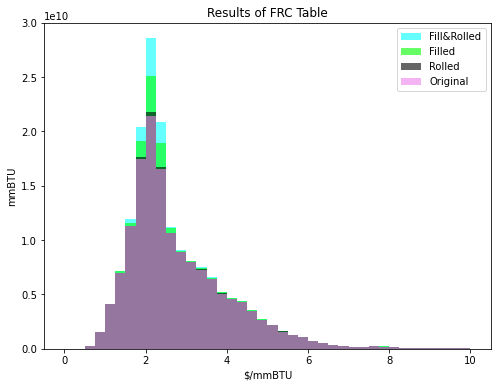

In [59]:
plt.figure(figsize=(8,6))
range=(0,10)
bins=40
alpha=.6

plt.hist(frc_rf.fuel_cost_per_mmbtu,range=range,bins=bins,
         label='Fill&Rolled',color='cyan',alpha=alpha,
         weights=frc_rf.total_heat_content_mmbtu
        );
plt.hist(frc_f.fuel_cost_per_mmbtu,range=range,bins=bins,
         label='Filled',alpha=alpha,color='lime',
         weights=frc_f.total_heat_content_mmbtu
        );
plt.hist(frc_r.fuel_cost_per_mmbtu,range=range,bins=bins,
         label='Rolled',alpha=alpha,color='black',
         weights=frc_r.total_heat_content_mmbtu
        );

plt.hist(frc_og.fuel_cost_per_mmbtu,range=range,bins=bins,
         label='Original',color='violet',alpha=alpha,
         weights=frc_og.total_heat_content_mmbtu
        );

plt.ylabel("mmBTU")
plt.xlabel("$/mmBTU")
plt.title("Results of FRC Table")
plt.legend()
plt.show()

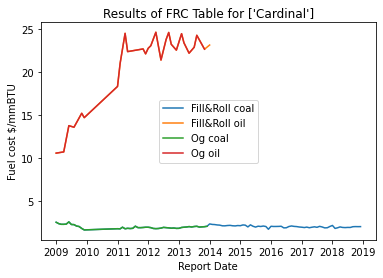

In [64]:
plot_filled_rolled_plant(frc_rf, frc_og)